### Libraries and dependancies

In [7]:
%pip install rioxarray -q
%pip install kornia -q
%pip install torchgeo lightly!=1.4.26 -q


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import rioxarray
import matplotlib.pyplot as plt
import os
from pathlib import Path

#Image and plot libraries

from matplotlib.figure import Figure
from collections.abc import Iterable, Sequence
from rasterio.crs import CRS
from typing import Any, Callable, Optional, Union, cast, Iterable, List

# Deep Learning libraries
import torch
import torchgeo
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomBatchGeoSampler, RandomGeoSampler, GridGeoSampler, Units
from torch.utils.data import DataLoader
from torchgeo.datamodules import GeoDataModule
from torchgeo.datasets.utils import BoundingBox


#lightning
import pytorch_lightning as pl


## Data exploration

### Image visualization

In [4]:
import boto3

s3 = boto3.client('s3')

In [5]:
bucket_name = "sagemaker-eu-central-1-036203601607"
s3_key = "wildifre_dataset/fire_landcover_000.tif"
local_path = "/root/wildfire prediction/test_images/fire_landcover_000.tif"

s3.download_file(bucket_name, s3_key, local_path)

In [6]:
bucket_name = "sagemaker-eu-central-1-036203601607"
s3_key = "wildifre_dataset/fire_mask_000.tif"
local_path = "/root/wildfire prediction/test_images/fire_mask_000.tif"

s3.download_file(bucket_name, s3_key, local_path)

In [32]:
from typing import Any, Optional, Union, cast
from matplotlib.figure import Figure

## See https://torchgeo.readthedocs.io/en/stable/tutorials/custom_raster_dataset.html
class BinaryFireDaset(RasterDataset):
    filename_glob = "*_landcover_*.tif"

    classes = {
        "no_wildfire": 0,
        "wildfire": 1,
    }

    def __len__(self) -> int:
        """Return the number of data points in the dataset.

        Returns:
            length of the dataset
        """
        return len(self.files)

    def __getitem__(self, query: BoundingBox) -> dict[str, Any]:
        """Retrieve image/mask and metadata indexed by query.

        Args:
            query: (minx, maxx, miny, maxy, mint, maxt) coordinates to index

        Returns:
            sample of image, mask and metadata at that index

        Raises:
            IndexError: if query is not found in the index
        """
        #print(query)
        hits = self.index.intersection(tuple(query), objects=True)

        filepaths = cast(list[str], [hit.object for hit in hits])
        print(filepaths)

        # print(filepaths)
        # print("=======================================")

        if not filepaths:
            raise IndexError(
                f"query: {query} not found in index with bounds: {self.bounds}"
            )

        image = self._merge_files(filepaths, query, self.band_indexes)

        mask_filepaths = []
        for filepath in filepaths:
            mask_filepath = filepath.replace('_landcover_', '_mask_')
            

            if os.path.isfile(filepath):
                pass
                # print(f"SCENE is a file.")
            else:
                print(f"{filepath} is not a file or does not exist.")

            if os.path.isfile(mask_filepath):
                pass
                # print(f"MASK is a file.")
            else:
                print(f"{mask_filepath} is not a file or does not exist.")
            # print(mask_filepath)
            
            #print(new_mask_path)
            mask_filepaths.append(mask_filepath)

        mask = self._merge_files(mask_filepaths, query)

        sample = {
            "crs": self.crs,
            "bbox": query,
            "image": image.float(),
            "mask": mask.long(),
        }

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

    def plot(
        self,
        sample: dict[str, Any],
        show_titles: bool = True,
        suptitle: Optional[str] = None,
    ) -> Figure:
        """Plot a sample from the dataset.

        Args:
            sample: a sample returned by :meth:`RasterDataset.__getitem__`
            show_titles: flag indicating whether to show titles above each panel
            suptitle: optional string to use as a suptitle

        Returns:
            a matplotlib Figure with the rendered sample

        .. versionchanged:: 0.3
           Method now takes a sample dict, not a Tensor. Additionally, possible to
           show subplot titles and/or use a custom suptitle.
        """
        image = sample["image"][0:3, :, :].permute(1, 2, 0) / 255.0

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

        ax.imshow(image)
        ax.axis("off")
        if show_titles:
            ax.set_title("Image")

        if suptitle is not None:
            plt.suptitle(suptitle)

        return fig
    
    def tplot(
        self,
        sample: dict[str, Any],
        show_titles: bool = True,
        suptitle: Optional[str] = None,
    ) -> Figure:
        """Plot a sample from the dataset.

        Args:
            sample: a sample returned by :meth:`RasterDataset.__getitem__`
            show_titles: flag indicating whether to show titles above each panel
            suptitle: optional string to use as a suptitle

        Returns:
            a matplotlib Figure with the rendered sample

        .. versionchanged:: 0.3
           Method now takes a sample dict, not a Tensor. Additionally, possible to
           show subplot titles and/or use a custom suptitle.
        """
        image = sample["image"][0:3, :, :].permute(1, 2, 0)

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

        ax.imshow(image)
        ax.axis("off")
        if show_titles:
            ax.set_title("Image")

        if suptitle is not None:
            plt.suptitle(suptitle)

        return fig

    def plot_mask(self, sample):
      mask = sample["mask"]
      fig, ax = plt.subplots()
      ax.imshow(mask.squeeze().numpy())
      ax.axis('off')
      return fig


In [121]:
test_imgs = BinaryFireDaset(paths="/root/wildfire prediction/test_images")

In [250]:
IMG_SIZE = 512
BATCH_SIZE = 1
SAMPLE_SIZE = 2000

sampler = RandomGeoSampler(train_imgs, size=IMG_SIZE, length=SAMPLE_SIZE)
dataloader = DataLoader(train_imgs, sampler=sampler, collate_fn=stack_samples, shuffle=False)

In [123]:
print(len(train_imgs))
print(len(sampler))
print(len(dataloader))

1
2000
2000


In [124]:
batch = next(iter(dataloader))

['/root/wildfire prediction/test_images/fire_landcover_000.tif']


torch.Size([4, 512, 512])
torch.Size([1, 512, 512])


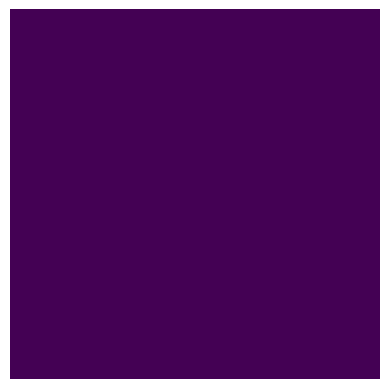

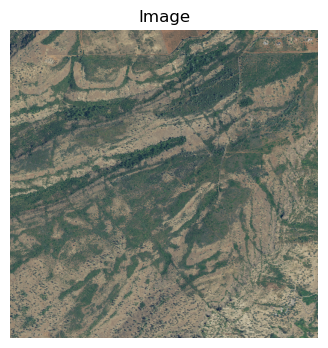

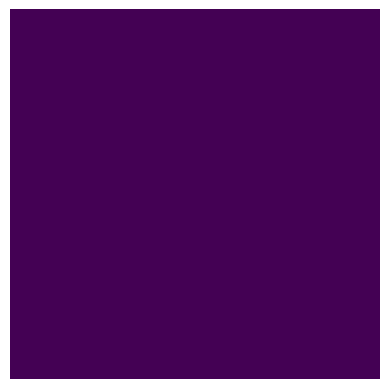

In [126]:
x, y = batch["image"], batch["mask"]
sample = unbind_samples(batch)[0]
image = sample["image"]
mask = sample["mask"]
print(image.shape)
print(mask.shape)
# print(image)
# print(mask)
train_imgs.plot(sample)
train_imgs.plot_mask(sample)

### Normalization

In [27]:
mean = [65.4478    , 80.930595  , 76.22475   ,  0.35543102]
std = [37.943012, 32.78429, 22.212017, 0.21529795]

mean = mean[0:3]
std = std[0:3]

In [43]:
class MyNormalize(torch.nn.Module):
    def __init__(self, mean: List[float], stdev: List[float]):
        super().__init__()

        self.mean = torch.Tensor(mean)[:, None, None]
        self.std = torch.Tensor(stdev)[:, None, None]

    def forward(self, inputs: dict):

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if inputs["image"].ndim == 4:
            x = (x - self.mean[None, ...]) / self.std[None, ...]

        else:
            x = (x - self.mean) / self.std

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs

    def revert(self, inputs: dict):
        """
        De-normalize the batch.
        Args:
            inputs (dict): Dictionary with the 'image' key
        """

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if x.ndim == 4:
            x = inputs["image"][:, : len(self.mean), ...]
            x = x * self.std[None, ...] + self.mean[None, ...]
        else:
            x = x * self.std + self.mean

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs

In [44]:
normalize = MyNormalize(mean=mean, stdev=std)

In [45]:
tfms = torch.nn.Sequential(normalize)

In [46]:
batch = next(iter(dataloader))

train_batch = tfms(batch)

['/root/wildfire prediction/test_images/fire_landcover_000.tif']


torch.Size([4, 512, 512])
torch.Size([1, 512, 512])


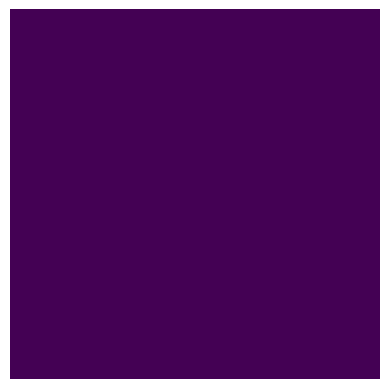

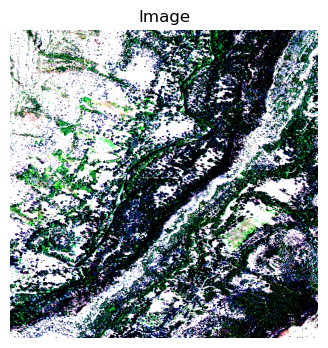

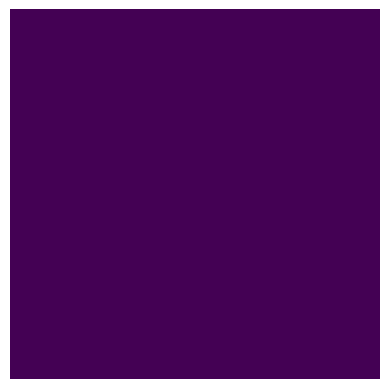

In [48]:
sample = unbind_samples(train_batch)[0]
image = sample["image"]
mask = sample["mask"]

print(image.shape)
print(mask.shape)
# print(image)
# print(mask)
train_imgs.tplot(sample)
train_imgs.plot_mask(sample)

## Processing / training job

In [19]:
!pip install shortuuid


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [20]:
import boto3
import shortuuid
import sagemaker
from sagemaker import get_execution_role

from sagemaker.pytorch.processing import PyTorchProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

sm_session = sagemaker.Session()
role = get_execution_role()
s3_resource = boto3.resource('s3')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [21]:
processing_name = "data_processing"

# Create a short unique identifier
short_id = shortuuid.uuid()

# Create job_name by combining training_name with the shorter unique identifier
job_name = '{}-{}'.format(processing_name, short_id)

print(job_name)

data_processing-V375rjZLV5vosxeBJBMhyq


In [50]:
processor = PyTorchProcessor(
    framework_version='2.1.0',
    py_version='py310',
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.8xlarge"
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


In [49]:
processor.run(
    inputs=[ProcessingInput(source='s3://sagemaker-eu-central-1-036203601607/wildifre_dataset/', destination='/opt/ml/processing/input/data')],
    outputs=[ProcessingOutput(source='/opt/ml/processing/model')],
    code='train_no.py', source_dir='src'
)

INFO:sagemaker.processing:Uploaded src to s3://sagemaker-eu-central-1-036203601607/pytorch-2024-02-20-17-24-37-265/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-eu-central-1-036203601607/pytorch-2024-02-20-17-24-37-265/source/runproc.sh
INFO:sagemaker:Creating processing-job with name pytorch-2024-02-20-17-24-37-265


Using provided s3_resource
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150.2 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 59.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 31.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.1/684.1 kB 128.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.5/378.5 kB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

## Model deployment and predictions

### Functions and mappings

In [385]:
def create_in_memory_geochip(predicted_chip, geotransform, crs, color_coded=False):
    """
    Apply georeferencing to the predicted chip.
    
    Parameters:
        predicted_chip (numpy array): The predicted segmentation chip (e.g., binary mask).
        geotransform (tuple): A tuple containing the geotransformation information of the chip (x-coordinate of the top left corner, x and y pixel size, rotation, y-coordinate of the top left corner, and rotation).
        crs (str): Spatial Reference System (e.g., EPSG code) of the chip.
        color_coded (bool): If the chip is color coded, it has a shape [H, W, C], othersize has a shape [1, H, W]

    Return:
        A rasterio dataset that is georreferenced.
    """
    if color_coded:
        predicted_chip = np.rollaxis(predicted_chip, axis=2) # putting the bands first
        photometric = 'RGB'
    else:
        photometric = 'MINISBLACK'
        
    memfile = MemoryFile()
    dataset = memfile.open(
        driver='GTiff',
        height=predicted_chip.shape[1],
        width=predicted_chip.shape[2],
        count=predicted_chip.shape[0],  # Number of bands
        dtype=np.uint8,
        crs=crs,
        transform=geotransform,
        photometric=photometric,
    )
    
    dataset.write(predicted_chip)
    return dataset

In [387]:
def merge_georeferenced_chips(chips_list, output_path):
    """
    Merge a list of georeferenced chips into a single GeoTIFF file.

    Parameters:
        chips_generator (generator): A generator of Rasterio datasets representing the georeferenced chips.
        output_path (str): The path where the merged GeoTIFF file will be saved.

    Returns:
        None
    """
    # Merge the chips using Rasterio's merge function
    merged, merged_transform = merge(chips_list)
    
    # Calculate the number of rows and columns for the merged output
    rows, cols = merged.shape[1], merged.shape[2]

    # Update the metadata of the merged dataset
    merged_metadata = chips_list[0].meta
    merged_metadata.update({
        'height': rows,
        'width': cols,
        'transform': merged_transform
    })

    # Write the merged array to a new GeoTIFF file
    with rasterio.open(output_path, 'w', **merged_metadata) as dst:
        dst.write(merged)
        
    for chip in chips_list:
        chip.close()

### test dataset and inference

In [171]:
import timeit
from rasterio.merge import merge
import rasterio

In [62]:
model = SemanticSegmentationTask.load_from_checkpoint("/root/wildfire prediction/models/last.ckpt") ## Here get your own checkpoint

# Set the model to evaluation mode
model.eval()

SemanticSegmentationTask(
  (criterion): CrossEntropyLoss()
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassJaccardIndex): MulticlassJaccardIndex(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassJaccardIndex): MulticlassJaccardIndex(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassJaccardIndex): MulticlassJaccardIndex(),
    prefix=test_
  )
  (model): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_

In [409]:
IMG_SIZE = 512
BATCH_SIZE = 512
SAMPLE_SIZE = 2000

sampler = GridGeoSampler(train_imgs, size=IMG_SIZE, stride= 256)
dataloader = DataLoader(train_imgs, sampler=sampler, collate_fn=stack_samples, shuffle=False)

In [410]:
OUTPUT_DIR = '/root/wildfire prediction/output'

## color map:
##    Purple: No fire
##    Yellow: Fire

In [411]:
len(dataloader)

35

In [428]:
crs = train_imgs.crs.to_epsg()
pixel_size = train_imgs.res

4.4915764205976074e-05

In [460]:
georref_chips_list = []
color_coded=False
item_number = 18

for i, sample in enumerate(dataloader):
    if i == item_number:
        batch = sample
        image, gt_mask, bbox = sample['image'], sample['mask'], sample['bbox'][0]
        
        image = image/255. # as I'm not using a GeoDatamodule, I need to divide de images by 255 manually

        prediction = model.model.predict(image)
        prediction = torch.softmax(prediction, dim=1)
        prediction = torch.argmax(prediction, dim = 1)
        
        geotransform = from_origin(bbox.minx, bbox.maxy, pixel_size, pixel_size)
               
        georref_chips_list.append(create_in_memory_geochip(prediction, geotransform, crs, color_coded))
        
        break
        
    else:
        pass
        

['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire prediction/test_images/fire_landcover_000.tif']
['/root/wildfire predicti

In [461]:
merge_georeferenced_chips(georref_chips_list, file_name)

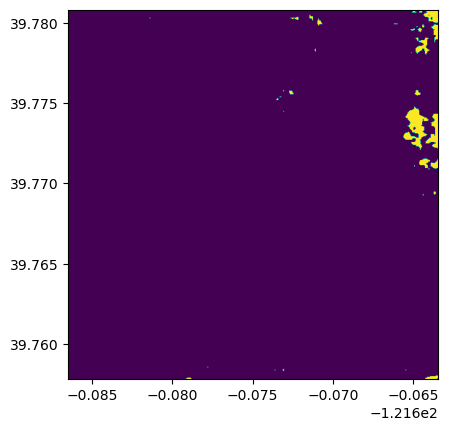

/root/wildfire prediction/output/merged_prediction.tif


In [462]:
from rasterio.plot import show

output_filepath = os.path.join(OUTPUT_DIR, 'merged_prediction.tif')
src = rasterio.open(output_filepath)
show(src.read(), transform=src.transform)
print(output_filepath)

torch.Size([4, 512, 512])
torch.Size([1, 512, 512])


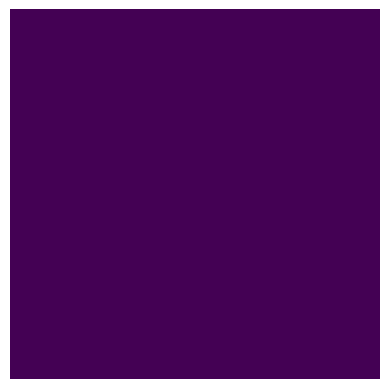

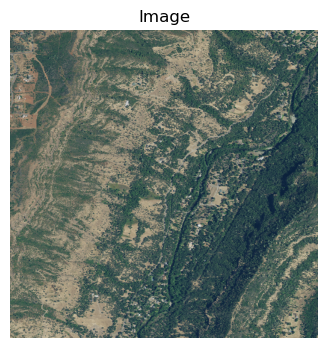

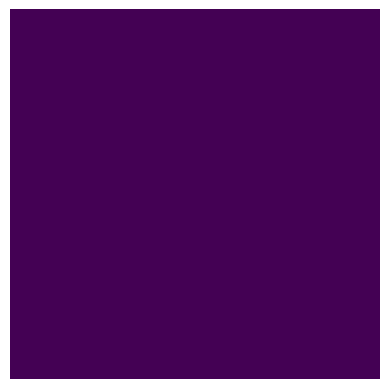

In [463]:
sample = unbind_samples(batch)[0]
image = sample["image"]
mask = sample["mask"]
print(image.shape)
print(mask.shape)
# print(image)
# print(mask)
train_imgs.plot(sample)
train_imgs.plot_mask(sample)

## Appendix